# Overall
This note book shows the procedure to produce the scalability performance plot from DALiuGE

In [24]:
import os, sys, string, time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)


## Schema of the dataset
    0.  user name (e.g. cwu)
    1.  facility (e.g. galaxy)
    2.  pipeline (e.g. lofar_std)
    3.  time (e.g. 2016-08-22T11-52-11/)
    4.  # of nodes
    5.  # of drops
    6.  Git commit number
    7.  unroll_time
    8.  translation_time
    9.  pg_spec_gen_time
    10. created_session_at_all_nodes_time
    11. graph_separation_time
    12. push_sub_graphs_to_all_nodes_time
    13. created_drops_at_all_nodes_time
    14. Num_pyro_connections_at_all_nodes
    15. created_pyro_conn_at_all_nodes_time
    16. triggered_drops_at_all_nodes_time
    17. Total completion time

## Load the dataset

In [2]:
csv_file = 'presult_5_Sep_2016.csv'
df = pd.read_csv(csv_file, header=None)

num_tests, num_attr = df.shape
print("In total {0} tests run and {1} attributes recorded".format(num_tests, num_attr))
# just show the first three examples
df

In total 168 tests run and 18 attributes recorded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,cwu,magnus,lofar_test_128x128,2016-08-31T11-57-07,30,264902,b0142623e6b180de8302273efdc18cb046f389ef,33.733,652.317,0.192,0.019,4.41399979591,2.388,96.6419999599,-1,None,0.12299990654,513.732
1,cwu,magnus,lofar_test_64x64,2016-08-31T12-40-40,60,66918,b0142623e6b180de8302273efdc18cb046f389ef,3.329,35.359,0.044,0.040,0.957999944687,1.521,5.65199995041,-1,None,0.0710000991821,407.761
2,cwu,magnus,lofar_test_32x32,2016-08-29T21-00-57,30,17078,b0142623e6b180de8302273efdc18cb046f389ef,0.344,1.140,0.012,0.018,0.151000022888,0.769,0.375999927521,9186,14.9320001602,2.53399991989,477.997
3,cwu,magnus,lofar_test_16x16,2016-09-01T16-49-53,30,4446,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.063,0.170,0.003,0.020,0.0310001373291,0.616,0.0820000171661,-1,None,0.0160000324249,402.303
4,cwu,magnus,lofar_test_64x64,2016-08-31T12-40-42,60,66918,b0142623e6b180de8302273efdc18cb046f389ef,3.323,36.183,0.045,0.036,0.962999820709,1.487,5.65299987793,-1,None,0.0699999332428,407.726
5,cwu,magnus,lofar_test_64x128,2016-08-27T10-43-59,30,133830,b0142623e6b180de8302273efdc18cb046f389ef,10.372,9.015,0.097,0.018,1.89499998093,1.471,5.83200001717,66584,620.299999952,20.8169999123,1161.858
6,cwu,magnus,lofar_test_4x4,2016-08-24T10-49-18,9,348,None,0.005,0.285,0.001,0.010,0.00200009346008,0.342,0.0939998626709,154,0.450999975204,0.0390000343323,-1.000
7,rtobar,magnus,lofar_test_128x128,2016-09-05T17-14-42,30,264902,579e6f0ce24bfd1786b8a90addcccda0895344be,34.536,12.599,0.192,0.020,4.44099998474,2.350,83.8959999084,-1,None,0.168999910355,92.391
8,cwu,magnus,lofar_test_64x64,2016-08-29T19-58-32,60,66918,b0142623e6b180de8302273efdc18cb046f389ef,3.396,4.350,0.049,0.035,0.94000005722,1.531,1.48099994659,38008,164.638999939,10.8100001812,681.870
9,cwu,magnus,lofar_test_16x32,2016-08-27T10-40-36,60,8886,b0142623e6b180de8302273efdc18cb046f389ef,0.146,0.686,0.006,0.034,0.0820000171661,1.099,0.18799996376,4942,3.99000000954,1.30099987984,406.954


## Set the filter
Show tests that have successfully completed its execution on 30 nodes (sort based on # of drops and # of relationships)

In [3]:
def filter_data(num_nodes=None, gt_num_drops=None, lt_num_drops=None, 
                git_commit=None, user=None, pipeline=None, 
                gt_test_date=None, lt_test_date=None, lt_trans_time=None, 
                gt_trans_time=None, gt_drop_create_time=None,
                gt_completion_time=None, lt_completion_time=None, filter_none=[16]):
    
    col_list = list(string.ascii_lowercase[0:18])
    rt = pd.DataFrame(df.values, columns=col_list)
    cond = []
    if (num_nodes != None):
        cond.append('e == %d' % num_nodes)
    if (gt_num_drops != None):
        cond.append('%s >= %d' % (col_list[5], gt_num_drops))
    if (lt_num_drops != None):
        cond.append('%s <= %d' % (col_list[5], lt_num_drops))
    if (lt_trans_time != None):
        cond.append('%s <= %d' % (col_list[8], lt_trans_time))
    if (gt_trans_time != None):
        cond.append('%s >= %d' % (col_list[8], gt_trans_time))
    if (lt_completion_time != None):
        cond.append('%s <= %d' % (col_list[17], lt_completion_time))
    if (gt_completion_time != None):
        cond.append('%s >= %d' % (col_list[17], gt_completion_time))
    if (git_commit != None):
        cond.append('%s == "%s"' % (col_list[6], git_commit))
    if (user != None):
        cond.append('%s == "%s"' % (col_list[0], user))
    if (pipeline != None):
        cond.append('%s == "%s"' % (col_list[2], pipeline))
    if (gt_test_date != None):
        cond.append('%s >= "%s"' % (col_list[3], gt_test_date))
    if (lt_test_date != None):
        cond.append('%s <= "%s"' % (col_list[3], lt_test_date))
    for rm in filter_none:
        cond.append('%s != "None"' % col_list[rm])
        cond.append('%s != -1' % col_list[rm])
    rt = pd.DataFrame(rt.query(' & '.join(cond)).values)
    return rt.sort_values(by=[5, 14])
#test_filter = filter_data(60, lt_num_drops=10000, lt_test_date='2016-08-29T21-00-56')
#test_filter = filter_data(user='cwu', filter_none=[17], gt_test_date='2016-08-31T00-00-56')
df = filter_data(filter_none=[6,7,8])
test_filter = filter_data(user='cwu', filter_none=[17],
                         gt_test_date='2016-08-31T00-00-56', lt_trans_time=30)
test_filter.shape
test_filter

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,cwu,magnus,lofar_test_8x16,2016-09-01T16-44-38,30,2226,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0320001,0.0709999,0.00100017,0.02,0.0169999599457,0.693,0.0320000648499,-1,None,0.0139999389648,326.33
1,cwu,magnus,lofar_test_8x16,2016-09-01T16-44-52,60,2226,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0320001,0.0760002,0.000999928,0.0369999,0.0220000743866,1.024,0.0450000762939,-1,None,0.0309998989105,239.319
2,cwu,magnus,lofar_test_8x16,2016-09-01T16-44-54,60,2226,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0319998,0.0749998,0.00100017,0.0370002,0.0220000743866,1.019,0.0519998073578,-1,None,0.029000043869,239.269
3,cwu,magnus,lofar_test_8x16,2016-09-01T16-44-49,60,2226,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0319998,0.075,0.00199986,0.0379999,0.0230000019073,0.936,0.0510001182556,-1,None,0.0289998054504,239.255
4,cwu,magnus,lofar_test_8x16,2016-09-01T16-44-26,30,2226,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0320001,0.0710001,0.000999928,0.0190001,0.0169999599457,0.743,0.0889999866486,-1,None,0.0190000534058,326.352
5,cwu,magnus,lofar_test_8x16,2016-09-05T14-54-40,30,2226,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0320001,0.072,0.00100017,0.02,0.0160000324249,0.7,0.0329999923706,-1,None,0.0150001049042,0.186
6,cwu,magnus,lofar_test_8x16,2016-09-01T16-44-41,30,2226,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0309999,0.072,0.000999928,0.0210001,0.0169999599457,0.636,0.0320000648499,-1,None,0.0150001049042,326.283
7,cwu,magnus,lofar_test_16x16,2016-09-01T16-49-53,30,4446,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.063,0.17,0.00300002,0.02,0.0310001373291,0.616,0.0820000171661,-1,None,0.0160000324249,402.303
8,cwu,magnus,lofar_test_16x16,2016-09-01T16-49-55,30,4446,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0639999,0.17,0.00199986,0.02,0.0310001373291,0.635,0.0830001831055,-1,None,0.0160000324249,402.281
9,cwu,magnus,lofar_test_16x16,2016-09-01T16-49-44,60,4446,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.0650001,0.178,0.00300002,0.039,0.039999961853,1.015,0.0720000267029,-1,None,0.029000043869,336.342


## Plot 1
The first set of graphs show the time spend on varoius metrics when we increase the number of Drops or Drop relationships given a fixed set of nodes (e.g. 30 or 60).

After filtering as shown above, we also want to make sure all data values of our intersted columns are of "numeric" type, and we also want to sort the dataset based on the number of Drops as this plot requires

In [4]:
col_list = [5] + list(range(7, 18))
ttr = test_filter[col_list].sort_values(by=[5])
ttr[col_list] = ttr[col_list].apply(pd.to_numeric, errors='coerce')

Then, we let Pandas do the heavy-lifting of data aggregation and calculation

In [5]:
#ttr.groupby([5]).mean()

Just to make sure the above group by aggregation is correct:

Let Pandas calculate the error as well:

In [6]:
#ttr.groupby([5]).std()

Based on the above playing around, we are able to write a function to do the plotting job:

In [7]:
def plot_time_vs_drops(runs_data, num_nodes, pyro_time=False):
    """
    pyro_time: include time for establishing pyro relationships?
                default=True
    """
    col_list = [5] + list(range(7, 18))
    ttr = runs_data[col_list].sort_values(by=[5])
    ttr[col_list] = ttr[col_list].apply(pd.to_numeric, errors='coerce')
    
    yv = ttr.groupby([5]).mean()
    x = yv.index.values
    x_label = '# of Drops'
    y1 = yv.ix[:, 7:13].values
    y4 = yv.ix[:, 16:17].values
    
    ye = ttr.groupby([5]).std()
    ye1 = ye.ix[:, 7:13].values
    ye4 = ye.ix[:, 16:17].values.astype(float)

    labels_1 = ['unroll', 'translate', 'pg_spec', 'session', 'separation', 'push_graph', 'created_drop']
    marker_1 = ['o', 'v', '^', '8', 's', 'x', 'D']
    labels_2 = ['trigger', 'execution']
    marker_2 = marker_1[0:5]
    f = plt.figure(1)
    f.suptitle("Time spent when increasing the {1} running on {0} nodes".format(num_nodes, x_label), fontsize=17)
    plt.subplot(121)
    for i in range(len(labels_1)):
        lines = plt.errorbar(x, y1[:, i], linewidth=2, label=labels_1[i], yerr=ye1[:, i],
                 marker=marker_1[i], markersize=9, markerfacecolor='none', markeredgewidth=2)
        lines[0].set_markeredgecolor(lines[0].get_color())
    plt.legend(loc='upper left', fontsize=15)
    plt.ylabel('Seconds', fontsize=15)
    plt.xlabel(x_label, fontsize=15)
    plt.title('Preparation related time', fontsize=15)
    plt.subplot(122)
    for i in range(len(labels_2)):
        lines = plt.errorbar(x, y4[:,i], linewidth=2, label=labels_2[i], yerr=ye4[:, i],
                 marker=marker_2[i], markersize=9, markerfacecolor='none', markeredgewidth=2)
        lines[0].set_markeredgecolor(lines[0].get_color())
    orientation = 'upper right' if pyro_time else 'upper left'
    plt.legend(loc=orientation, fontsize=15)
    plt.ylabel('Seconds', fontsize=15)
    plt.xlabel(x_label, fontsize=15)
    plt.title('Execution related time', fontsize=15)


First, try 30 nodes

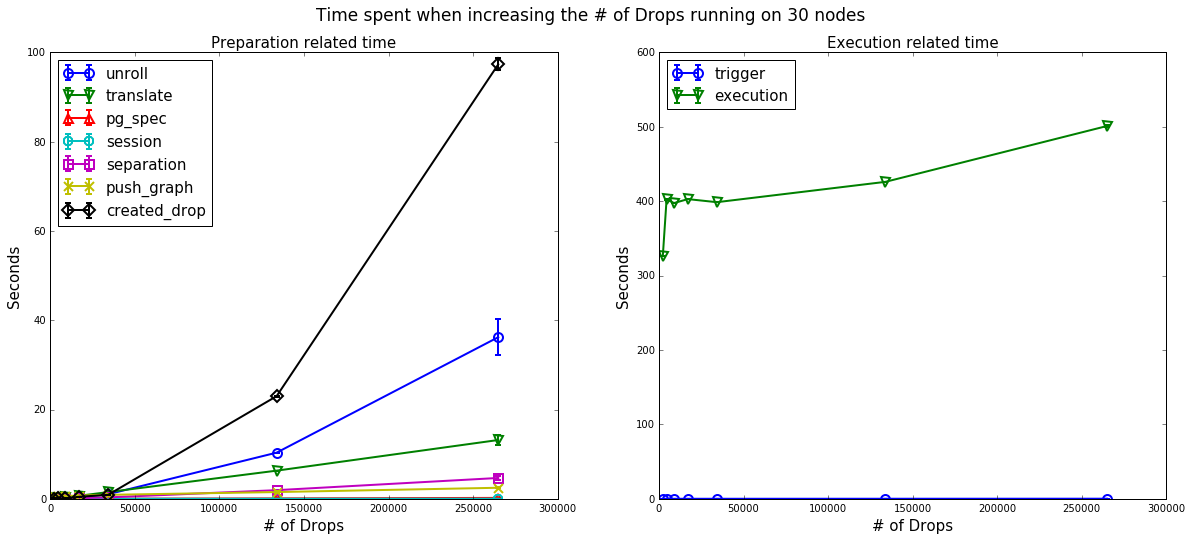

In [8]:
nb_nodes = 30
plot_time_vs_drops(filter_data(num_nodes=nb_nodes, user='cwu', filter_none=[17], 
                               gt_test_date='2016-08-31T00-00-56', lt_trans_time=20,
                              gt_completion_time=200), num_nodes=nb_nodes, 
                               pyro_time=False)

Notice that the "translation" time has **gone wild**. This is a bug that has been fixed in this [commit](https://github.com/SKA-ScienceDataProcessor/dfms/commit/fceac646a6dd06d5c80e47787bd87dbd971374ea). It should have been an order of magnitude lower, about 61 seconds for 264,920 drops.

Now try 60 nodes...

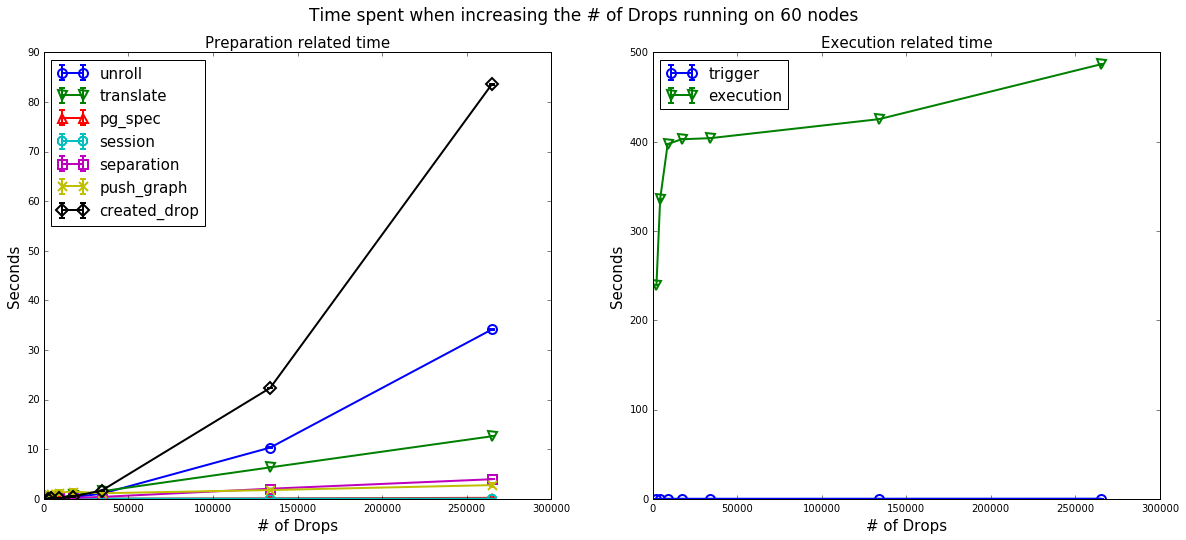

In [9]:
nb_nodes = 60
plot_time_vs_drops(filter_data(num_nodes=nb_nodes, user='cwu', filter_none=[17], 
                               gt_test_date='2016-08-31T00-00-56', lt_trans_time=20,
                              gt_completion_time=200), num_nodes=nb_nodes, 
                               pyro_time=False)


## Plot 2
The association between # of Drops and # of METIS Edge-cuts under different # of Nodes


In [10]:
def plot_edgecuts_vs_drops():
    markers = itertools.cycle(('o', 'v', '.', 'o', '*'))
    
    nb_drops = [499, 220, 348, 690, 1202, 2226, 4446, 8886, 17078, 34150, 66918, 133830, 264902]
    edge_cuts_30 = [593,
                 1038,
                 1151,
                 2034,
                 3584,
                 4192,
                 6475,
                 8531,
                 18927,
                 18608,
                 30135,
                 58615,
                 116436]
    edge_cuts_60 = [1035,
                 1819,
                 2552,
                 3045,
                 4077,
                 7689,
                 9545,
                 13333,
                 25918,
                 38970,
                 83067,
                 61884,
                 324568]
    ls = plt.plot(nb_drops, edge_cuts_30, label='30 nodes edgecuts', marker=markers.next(), 
                 markersize=10, markeredgewidth=2, markerfacecolor='none', linewidth=3, color='r')
    ls[0].set_markeredgecolor(ls[0].get_color())
    ls = plt.plot(nb_drops, edge_cuts_60, label='60 nodes edgecuts', marker=markers.next(), 
                 markersize=10, markeredgewidth=2, markerfacecolor='none', linewidth=3, color='y')
    ls[0].set_markeredgecolor(ls[0].get_color())
    plt.ylabel('# of METIS Edge cuts', fontsize=15)
    plt.xlabel('# of Drops', fontsize=15)
    plt.legend(loc='upper left', fontsize=15)
    

## Plot 3
the time spend on varoius metrics when we increase the # of nodes given a fixed set of Drops. Since the level of # of nodes is not so many, it is best to use a bar chart to illustrate this.

In [11]:
df30 = filter_data(filter_none=[17], gt_test_date='2016-08-31T00-00-56', 
                   gt_num_drops=None, num_nodes=30, user='cwu', 
                   gt_completion_time=200, lt_trans_time=100, gt_num_drops=5000)[[5, 17]]
df30

,5,17
0,2226,326.33
1,2226,326.352
2,2226,326.283
3,4446,402.303
4,4446,402.281
5,4446,402.281
6,8886,397.542
7,8886,397.514
8,8886,397.595
9,17078,402.795


In [12]:
df60 = filter_data(filter_none=[17], gt_test_date='2016-08-31T00-00-56', 
                   gt_num_drops=None, num_nodes=60, user='cwu', 
                   gt_completion_time=200, lt_trans_time=100, , gt_num_drops=5000)[[5, 17]]
df60

,5,17
0,2226,239.319
1,2226,239.269
2,2226,239.255
3,4446,336.342
4,4446,336.281
5,4446,336.32
6,8886,397.35
7,8886,397.391
8,8886,397.405
9,17078,402.672


In [13]:
dt1 = df30[17].astype(float)
df30_1 = pd.DataFrame({'17_30': list(dt1)}, index=list(df30[[5]].values[:,0]))
df30_mean = df30_1.groupby(df30_1.index).mean()
df30_err = df30_1.groupby(df30_1.index).std()
df30_mean

,17_30
2226,326.321667
4446,402.288333
8886,397.550333
17078,402.803333
34150,398.676000
66918,408.739000
133830,425.991667
264902,501.045556


In [14]:
dt2 = df60[17].astype(float)
df60_1 = pd.DataFrame({'17_60': list(dt2)}, index=list(df60[[5]].values[:,0]))
df60_mean = df60_1.groupby(df60_1.index).mean()
df60_err = df60_1.groupby(df60_1.index).std()
df60_mean

,17_60
2226,239.281000
4446,336.314333
8886,397.382000
17078,402.684000
34150,403.952000
66918,407.806333
133830,425.210333
264902,486.597333


In [15]:
both_df = df30_mean.join(df60_mean).sort_index()
both_df_err = df30_err.join(df60_err).sort_index()
both_df

,17_30,17_60
2226,326.321667,239.281000
4446,402.288333,336.314333
8886,397.550333,397.382000
17078,402.803333,402.684000
34150,398.676000,403.952000
66918,408.739000,407.806333
133830,425.991667,425.210333
264902,501.045556,486.597333


In [16]:
nodes_30 = both_df[['17_30']].values.flatten()
nodes_30_err = both_df_err[['17_30']].values.flatten()

In [17]:
nodes_60 = both_df[['17_60']].values.flatten()
nodes_60_err = both_df_err[['17_60']].values.flatten()

In [18]:
x_tick_labels = [str(x) + ' Drops' for x in sorted(both_df.index.values)]
x_tick_labels

['2226 Drops',
 '4446 Drops',
 '8886 Drops',
 '17078 Drops',
 '34150 Drops',
 '66918 Drops',
 '133830 Drops',
 '264902 Drops']

In [19]:
N = len(nodes_30)

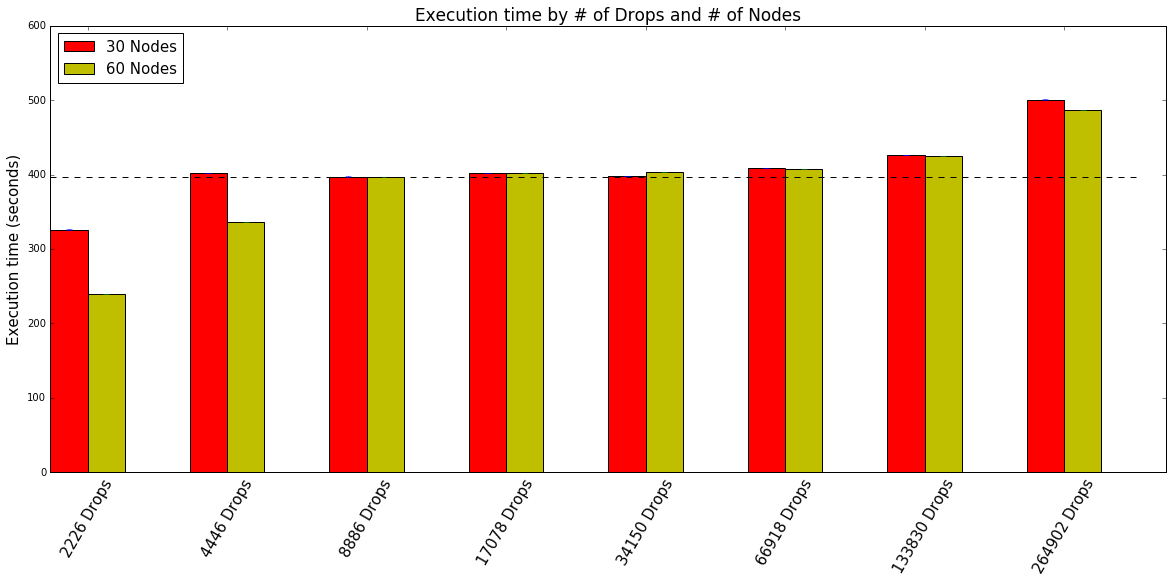

In [20]:
width = 0.4
ind = np.arange(N) * 1.5
b1 = plt.bar(ind, nodes_30, width, color='r', yerr=nodes_30_err)
b2 = plt.bar(ind + width, nodes_60, width, color='y', yerr=nodes_60_err)
plt.plot([0, ind[-1] + 3 * width], [397, 397], color='k', linestyle='--', linewidth=1)

plt.xticks(ind + width, x_tick_labels, fontsize=15, rotation=60)
plt.ylabel('Execution time (seconds)', fontsize=15)
plt.title('Execution time by # of Drops and # of Nodes', fontsize=17)
plt.legend((b1, b2), ('30 Nodes', '60 Nodes'), loc='upper left', fontsize=15)

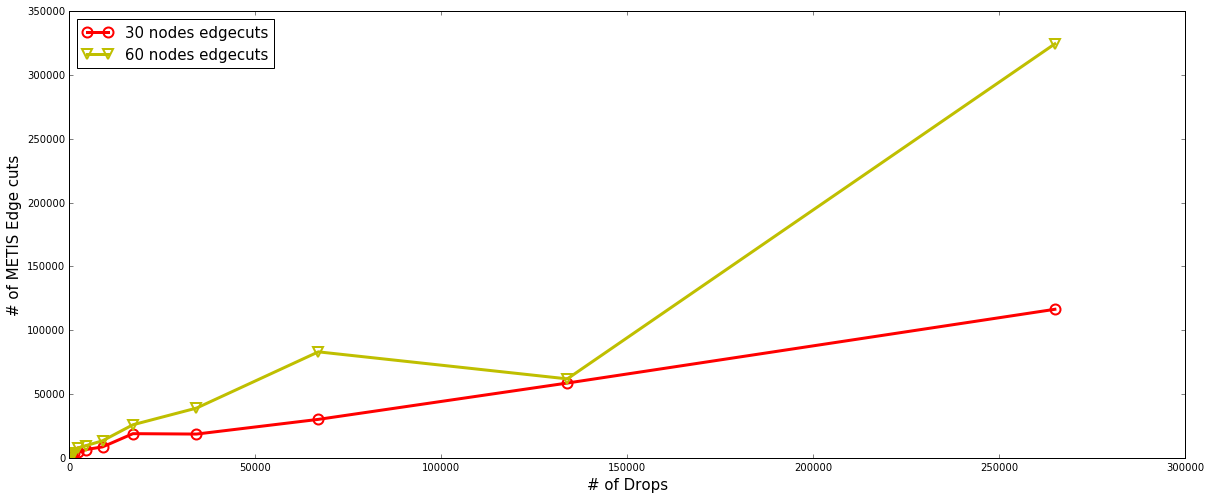

In [21]:
plot_edgecuts_vs_drops()

## Plot 4 - Event timeseries
Plot the event/message intensity over the time axis (time series of events). 
First for input, we need three log files: xx_execState.log, xx_session_running.log, xx_state.log

Step 1 - convert state into a Pandas dataframe (state event type, time)

In [46]:
dt_pattern = '%Y-%m-%dT%H:%M:%S,%f'
def get_timestamp(date_time):
    """
    microsecond precision
    """
    epoch = time.mktime(time.strptime(date_time, dt_pattern))
    return epoch
    #return datetime.strptime(date_time, dt_pattern).microsecond / 1e6 + epoch

In [164]:
ex_st_file = 'event_logs/64x128_execState.log'
st_file = 'event_logs/64x128_state.log'
ss_file = 'event_logs/64x128_session_running.log'

def go_thru_logs(st_file, session=False):
    ret = []
    with open(st_file) as esf:
        for line in esf.readlines():
            line = line.strip()
            s_sp = line.split()
            tstr = s_sp[0].split(':')[1] + 'T' + s_sp[1]
            ts = int(get_timestamp(tstr))
            if (session):
                ret.append(ts)
            else:
                node = int(line.split('/')[1])
                event = int(s_sp[-1])
                ret.append((ts, node, event))
    if (session):
        return max(ret)
    else:
        return ret

In [144]:
dst = go_thru_logs(st_file)
aest = go_thru_logs(ex_st_file)
ets = [dst, aest]

In [165]:
stt = go_thru_logs(ss_file, True)

In [192]:
def plot_event_timesries(ets, labels, stt, filters):
    """
    ets: a list of event numpy arrays, for each event array, the first column is the absoluate timestamp
    labels: a list of event labels/types
    stt: start time (integer)
    """
    bbmm = 1000
    tmp = []
    for a in ets:
        b = np.asarray(a)
        b0 = b[:,0] - stt
        bmin = np.min(b0)
        tmp.append((b, b0, bmin))
        bbmm = bmin if (bmin < bbmm) and (bmin < 0) else bbmm
        
    colors = itertools.cycle(('b', 'r', 'g'))
    max_end = 0
    for i, (b, b0, bmin) in enumerate(tmp):
        if (bbmm < 0):
            b0 -= bbmm
        fi = filters[i]
        if (fi is not None):
            x = b[:,2]
            b0 = b0[np.where(x == fi)] # each element is a relative timestamp (not an interval)
        ttt = np.max(b0)
        if ttt > max_end:
            max_end = ttt
        bc = np.bincount(b0)
        ii = np.nonzero(bc)[0]
        tt = zip(ii,bc[ii])
        xy = np.asarray(tt)
        x = xy[:,0]
        y = np.log10(xy[:,1])
        plt.plot(x, y, label=labels[i], color=colors.next(), linewidth=2)
    plt.grid(True)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Log10(# of Events)', fontsize=15)
    plt.legend(loc='upper right', fontsize=15)
    return max_end

489

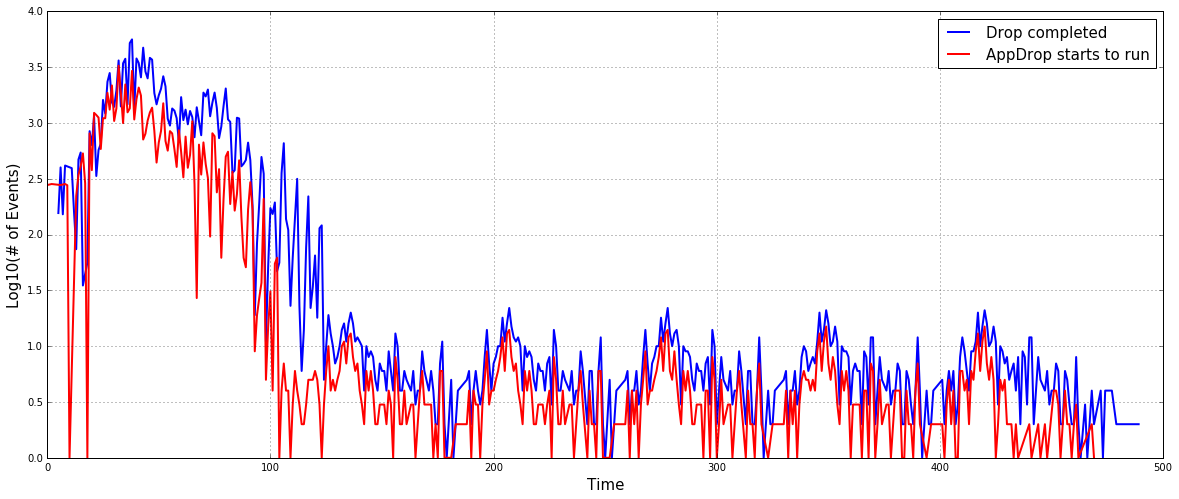

In [194]:
filters = [None, 1]
labels = ['Drop completed', 'AppDrop starts to run']
max_end = plot_event_timesries(ets, labels, stt, filters)
max_end

## Plot 5 - Event heatmap
In this type of plot, the color map represents the number of events, the X axis is the time, the Y axis is the compute node

In [190]:
len(aest)

134148

In [191]:
len(dst)

133830

In [214]:
def calc_event_heatmap(ets, labels, stt, filters, num_nodes):
    """
    ets: a list of event numpy arrays, for each event array, the first column is the absoluate timestamp
    labels: a list of event labels/types
    stt: start time (integer)
    """
    bbmm = 1000
    tmp = []
    for a in ets:
        b = np.asarray(a)
        b0 = b[:,0] - stt
        bmin = np.min(b0)
        tmp.append((b, b0, bmin))
        bbmm = bmin if (bmin < bbmm) and (bmin < 0) else bbmm
    matrix = np.zeros((num_nodes - 1, max_end + 1), dtype=np.float)
    for i, (b, b0, bmin) in enumerate(tmp):
        if (bbmm < 0):
            b0 -= bbmm
        fi = filters[i]
        b1 = b[:,1]
        if (fi is not None):
            x = b[:,2]
            ind = np.where(x == fi)
            b0 = b0[ind] # each element is a relative timestamp (not an interval)
            b1 = b1[ind]
        #print(len(b0), len(b1))
        for j, bt in enumerate(b0):
            matrix[b1[j] - 1][bt] += 1
            if (j % 5000 == 0):
                print(j)
    
    return matrix

In [215]:
mat = calc_event_heatmap(ets, labels, stt, filters, 60)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000


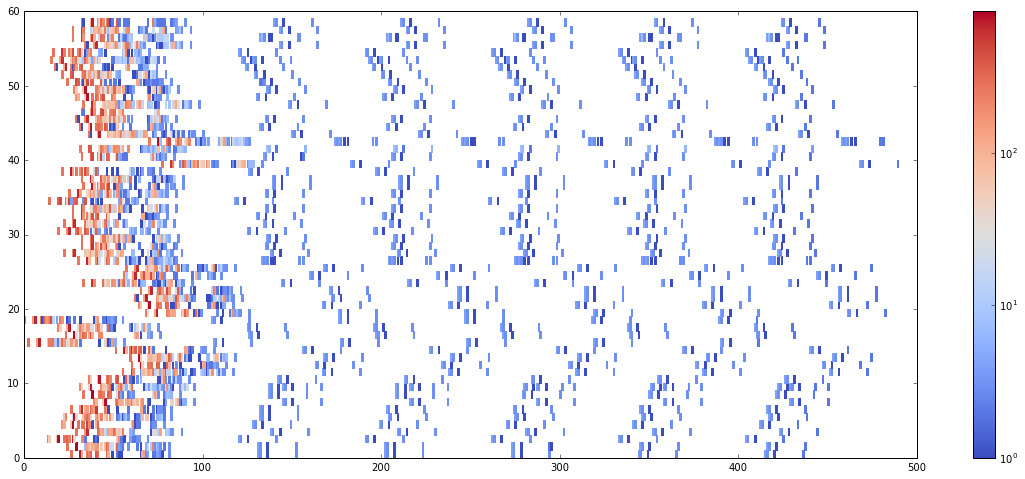

In [232]:
import matplotlib as mpl
plt.pcolor(mat, cmap=plt.cm.coolwarm, norm=mpl.colors.LogNorm())
plt.colorbar()